# Cloning a PHOENIX stellar model spectrum

Here we demo the first step of `blasé`, cloning a precomputed synthetic spectrum with a product-of-Voigt profiles approach.

In [1]:
import torch
from blase.emulator import SparseLinearEmulator
from gollum.phoenix import PHOENIXSpectrum
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Set the wavelength limits

We will target a relatively narrow chunk of spectrum: $11000 - 11180$ Å.  We use a $60$ Å buffer to deal with edge effects.

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic stellar spectrum

The [gollum](http://gollum-astro.readthedocs.io) precomputed synthetic spectral model interface makes this step pretty straightforward.  You don't even need to have the file locally-- gollum can fetch it for you.

In [4]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

The pristin PHOENIX spectrum needs to be flattened to facilitate line finding:  We first divide out the black body and then divide by a $5^{th}$ order polynomial.

In [5]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

## Clone the stellar model

We make an emulator for the spectrum by cloning all of the spectral lines above some prominence threshold:

In [6]:
%%capture
stellar_emulator = SparseLinearEmulator(stellar_spectrum.wavelength.value, 
                             stellar_spectrum.flux.value, 
                             wing_cut_pixels=6000, prominence=0.01, device=device)

The emulator found hundreds of spectral lines through a [heuristic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) process, and then instantiates a [Voigt profile](https://en.wikipedia.org/wiki/Voigt_profile) there.

In [7]:
len(stellar_emulator.lam_centers)

426

The `forward` pass of the model makes a spectrum that we can examine:

In [8]:
with torch.no_grad():
    stellar_pre = stellar_emulator.forward().cpu().numpy()

The initial guess should look lousy:

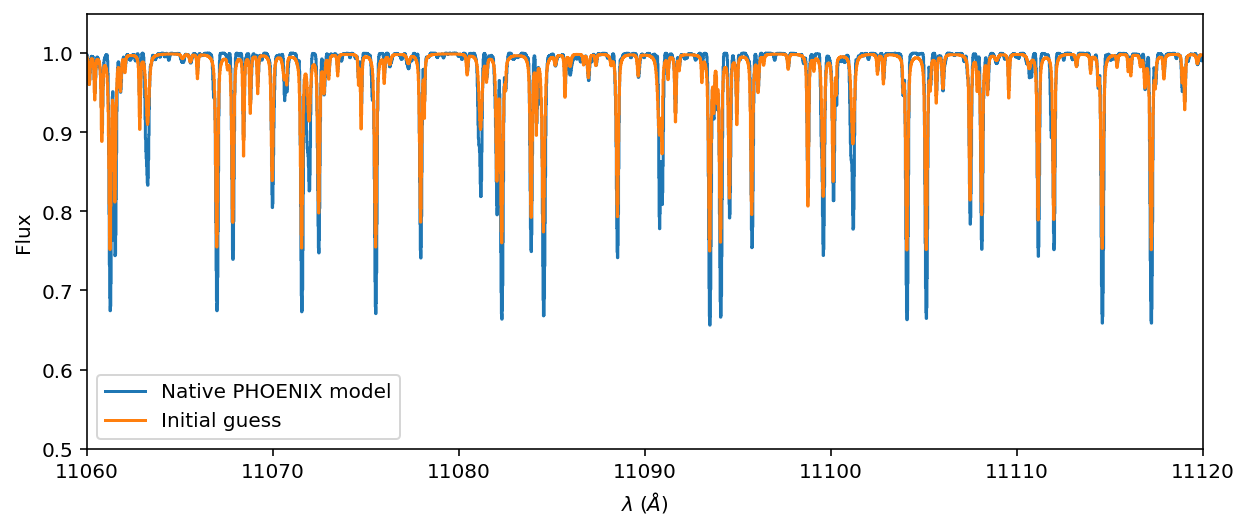

In [9]:
ax = stellar_spectrum.plot(ylo=0.5, yhi=1.05, label='Native PHOENIX model')
ax.step(stellar_spectrum.wavelength.value, stellar_pre, label='Initial guess')
ax.set_xlim(11_060, 11_120)
ax.legend();

The initialization is terrible! It's just a coarse guess that there is a line there with an approximate width and depth.  In the next step we will fine tune that guess.

### Fine-tune the model to clone the spectrum to near pixel-perfect

Here we adjust all of the properties of the lines simultaneously with the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm built into PyTorch.  Here we choose the bare minimum of 20 epochs with an aggressive learning rate (LR) of 0.05.  You should be able to get a better fit by running it for say 300 epochs, with a learning rate (LR) of 0.01, for example.  But it would take much longer.

In [10]:
stellar_emulator.optimize(epochs=20, LR=0.05)

Training Loss: 0.00022070: 100%|████████████████| 20/20 [00:29<00:00,  1.46s/it]


Now we can examine the spectrum, post fine-tuning.  It should provide a *much* better fit:

In [11]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().cpu().numpy()

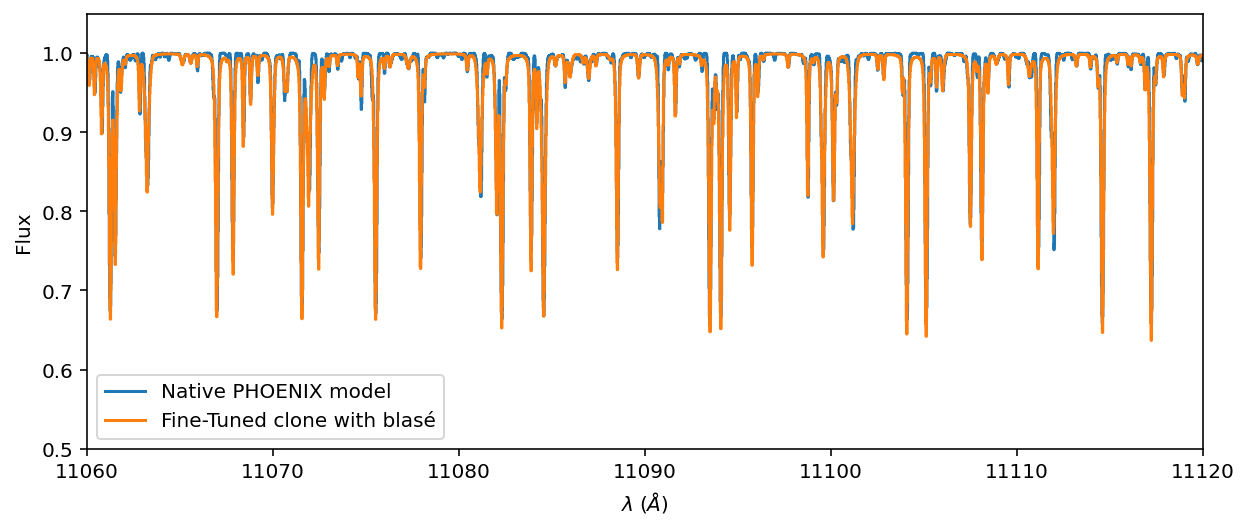

In [12]:
ax = stellar_spectrum.plot(ylo=0.5, yhi=1.05, label='Native PHOENIX model')
ax.step(stellar_spectrum.wavelength.value, stellar_post, label='Fine-Tuned clone with blasé')
ax.set_xlim(11_060, 11_120)
ax.legend();

Voilá! It's not perfect, but it's much better than before.  And recall that this is the clone at *native* resolution and pixel sampling.  Most models will ultimately be convolved with an instrumental kernel that will wash away most of these imperfections.

## Saving fine-tuned parameters as a "lookup table"

The collection of values for the wavelength centers, amplitudes, Gaussian widths, Lorentzian widths, and other parameters represents a reproducible snapshot of the model state:

> If you hand me the "lookup table" of these parameters, I can recreate the entire cloned forward model.  

In [13]:
torch.save(stellar_emulator.state_dict(), "phoenix_clone_T4700g4p5_prom0p01_11000Ang.pt")